
# **Monte Carlo simulations of the Two-Dimensional Ising model**

#  Project Carried out by Olatunji Toheeb Abayomi
Course : Kinetic Theory and Stochastic Simulations

**Lecturer -in-charge: Professor Matteo Colangeli**

In [ ]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt


from numba import jit, prange
from tqdm.auto import tqdm


#**Theory**#

## THE 2D ISING MODEL

We consider a 2-dimensional nearest-neighbour Ising Model with:
- $N^2=$ total number of sites on the lattice
- $\sigma_k \in \{+1,-1\}$ = individual spin site on the lattice

The Hamiltonian is:
$$ H(\vec{\sigma}) = - \sum_{<ij>} J_{ij} \sigma_i \sigma_j - \sum_i h_i\sigma_i$$
where $J_{ij}$ is the interaction strength and $h_i$ is the external local magnetic field.<br>
In this system, a particular configuration $\vec{\sigma}$ has the following probability:
$$ \pi(\vec{\sigma}) = \dfrac{e^{-\beta H(\vec{\sigma})}}{Z} $$
where
$$ Z = \sum_{ \{ \vec{\sigma} \} } e^{-\beta H(\vec{\sigma})} $$
is the partition function with $\beta = 1/k_B T$, and the sum is over all spin configurations of the system.

For $h = 0$, if the number of dimensions is larger than one, the Ising model shows a 2nd-order phase transitions. Then, below a certain critical temperature, a spontaneous magnetization occurs. For $d = 2$, the transition temperature has been calculated analytically by Onsager:
<br>
$$ T_C = \dfrac{2}{\ln(1 + \sqrt{2})}
$$

In our simulation, for simplicity, we choose an uniform ferromagnetic medium (i.e. $J_{ij}=J=1$) and no external field (i.e. $h_i=h=0$ ). We also fix $k_B = 1$. In this way our hamiltonian reduces to:
$$ H(\vec{\sigma}) = - \sum_{<ij>} \sigma_i \sigma_j$$
Finally we set the periodic boundary conditions, so all the spins have the same number of neighobours.

**Observables**

We compute the following quantities to understand the system's behavior:

Magnetization per spin
𝑚
(
𝑡
)
m(t) : Measures the average spin per site as a function of time, indicating the degree of alignment of spins.

**Energy per spin**
𝑒
(
𝑡
)
e(t): Measures the average energy per site as a function of time, indicating the stability of the configuration.

**Mean magnetization**
⟨
𝑚
⟩
⟨m⟩: Average magnetization over multiple configurations at different temperatures, indicating phase transitions.
Mean energy
⟨
𝑒
⟩
⟨e⟩: Average energy over multiple configurations at different temperatures, providing insights into energy fluctuations.


Magnetic susceptibility
𝜒 χ: Measures the response of the magnetization to changes in temperature, indicating critical behavior near
𝑇
𝑐
T
c
​
 .

**Specific heat**
𝐶
C: Measures the response of the energy to changes in temperature, indicating energy fluctuations near
𝑇
𝑐
T
c
​
 .

 We start with a random configuration:

In [ ]:
@jit(nopython=True)
def init_state(N):
  '''
  Return a random spin configuration in a 2d square lattice
  '''
  return np.random.choice(np.array([-1,1]),size=(N,N))

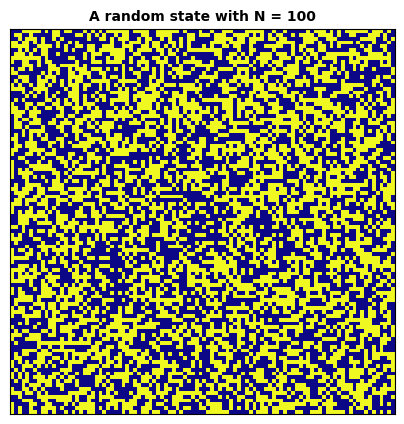

In [ ]:
try_state = init_state(100)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(try_state, cmap = plt.cm.plasma)
ax.set_xticks([])
ax.set_yticks([])
plt.title('A random state with N = 100', fontsize = 10, fontweight = "bold" )
plt.show()

In [ ]:
import numpy as np
from numba import jit, prange

@jit(nopython=True, parallel=True)
def energy(state):
    '''
    Energy of a given configuration
    '''
    N = state.shape[0]
    energy = 0

    # Loop over all sites
    for i in prange(N):
        for j in prange(N):

            # Get nearest neighbours states
            nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N]
            # Compute site energy
            energy -= state[i, j] * nn

    # Divide energy by 2, since we count each site contribution to each of the 2 neighbours
    return energy / 2

# Example usage:
N = 10
state = np.random.choice([-1, 1], size=(N, N))
print("Energy of the state:", energy(state))


Energy of the state: 4.0


In [ ]:
@jit(nopython=True)
def glauber(state, beta):
  '''
  Spin-flip according to Metropolis-Hastings algorithm
  '''
  N = state.shape[0]

  for n in prange(N**2):

      # choose a spin site with uniform probability
      i, j = np.random.randint(N), np.random.randint(N)

      # get sum of nearest neighbour values in the lattice
      nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N] # the modulo % operation takes care of the boundaries condition

      # get delta energy
      delta = 2 * state[i,j] * nn

      # Metropolis
      if delta < 0 or np.random.random() < np.exp(- beta * delta):
        state[i,j] = -1. * state[i,j]

  return state

### We consider the instance of a Single Spin Flip:

Example of single spin flip:


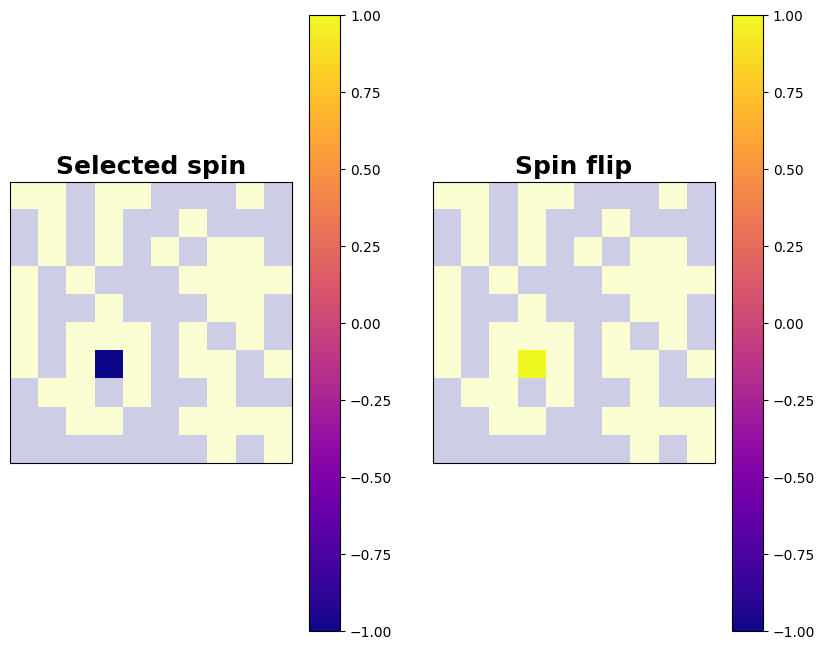

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize the state with random spins (+1 or -1)
def init_state(N):
    return np.random.choice([-1, 1], size=(N, N))

N = 10
beta = 1
state = init_state(N)
new_state = state.copy()

alpha = np.full((N, N), 0.2)

# Select a random spin to flip
i, j = np.random.randint(N), np.random.randint(N)
new_state[i, j] = -1. * new_state[i, j]

selected_spin = np.where(state != new_state)
alpha[selected_spin[0], selected_spin[1]] = 1

print("Example of single spin flip:")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

# Plot the original state with the selected spin highlighted
cax1 = ax1.matshow(state, cmap=plt.cm.plasma, alpha=alpha)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Selected spin", fontsize=18, fontweight="bold")

# Plot the new state after the spin flip
cax2 = ax2.matshow(new_state, cmap=plt.cm.plasma, alpha=alpha)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Spin flip", fontsize=18, fontweight="bold")

# Add colorbars to the plots
fig.colorbar(cax1, ax=ax1)
fig.colorbar(cax2, ax=ax2)

plt.show()


In [ ]:
def Ising(N, beta, eq_steps = int(1e4), steps = int(1e6), order = False, annealing = False, cluster = False, verbose=True):
    '''
    Run a simulation of a 2d Ising model

    Parameters:
    - N: number of sites per dimension
    - beta
    - eq_steps: initial steps for the equilibration phase
    - steps: effective steps of the simulation
    - order: generate a ordered configuration with uniform magnetisation
    - annealing: using simulating annealing during equilibration
    - cluster: to use the Wolff algorithm
    - verbose: more detailed output during simulation

    Output:
    - E_mean: Mean energy
    - M_mean: Mean magnetization
    - Cs: Specific heat
    - Chis: Susceptibility
    - E_var: Energy error
    - M_var: Magnetisation error
    - E_eq: Energy on equilibration
    - M_eq: Magnetisation on equilibration
    - E: Energy on simulation
    - M Magnetisation on simulation

    '''


    if verbose:
        print('---------- ISING MODEL ----------')
        print('N:', N, ', beta:', beta, ', cluster:', cluster, ', annealing:', annealing , '\n')

        print('Start equilibration...')

  # Init state
    if order:
        curr_state = np.ones((N,N))
    else:
        curr_state = init_state(N)

    E_eq = np.zeros(eq_steps)
    M_eq = np.zeros(eq_steps)

    if annealing:
        betas = np.zeros(eq_steps)
        N_annealing = eq_steps-eq_steps//10
        betas[:N_annealing] = np.linspace(0.1, beta, num=N_annealing, endpoint=True)
        betas[N_annealing:] = beta
    else:
    ### Equilibration
        betas = np.zeros(eq_steps) + beta

  # Loop over time steps
    if verbose:
        for i in tqdm(range(eq_steps)):
            #keep trace of energy and magnetisation
            E_eq[i] = energy(curr_state)
            M_eq[i] = np.sum(curr_state)
            #update the state
            curr_state = glauber(curr_state, betas[i])

        print('End equilibration...\n')

    else:
        for i in range(eq_steps):
            #keep trace of energy and magnetisation
            E_eq[i] = energy(curr_state)
            M_eq[i] = np.sum(curr_state)
            #update the state
            curr_state = glauber(curr_state, betas[i])

  ### Simulation
    if verbose:
        print('Start simulation...')

  # Define arrays for storing state observables
    E = np.zeros(steps)
    M = np.zeros(steps)

    if verbose:
        for i in tqdm(range(steps)):
            #keep trace of energy and magnetisation
            E[i] = energy(curr_state)
            M[i] = np.sum(curr_state)
            # Evolve state
            curr_state = glauber(curr_state, beta)
        print('End simulation...')

    else:
        for i in range(steps):
          #keep trace of energy and magnetisation
            E[i] = energy(curr_state)
            M[i] = np.sum(curr_state)
          # Evolve state
            curr_state = glauber(curr_state, beta)

    ### Compute observables
    E_mean, M_mean, C, Chi = np.mean(E), np.mean(M), beta**2*np.std(E)**2, beta*np.std(M)**2
    E_var, M_var = np.std(E), np.std(M)

  ### Return results
    return (E_mean, M_mean, C, Chi,
            E_var, M_var,
            E_eq, M_eq, E, M)





# **SIMULATION PROCESS**

---------- ISING MODEL ----------
N: 20 , beta: 0.2 , cluster: False , annealing: False 

Start equilibration...


  0%|          | 0/1000 [00:00<?, ?it/s]

End equilibration...

Start simulation...


  0%|          | 0/100 [00:00<?, ?it/s]

End simulation...
---------- ISING MODEL ----------
N: 20 , beta: 0.44 , cluster: False , annealing: False 

Start equilibration...


  0%|          | 0/1000 [00:00<?, ?it/s]

End equilibration...

Start simulation...


  0%|          | 0/100 [00:00<?, ?it/s]

End simulation...
---------- ISING MODEL ----------
N: 20 , beta: 1.0 , cluster: False , annealing: False 

Start equilibration...


  0%|          | 0/1000 [00:00<?, ?it/s]

End equilibration...

Start simulation...


  0%|          | 0/100 [00:00<?, ?it/s]

End simulation...


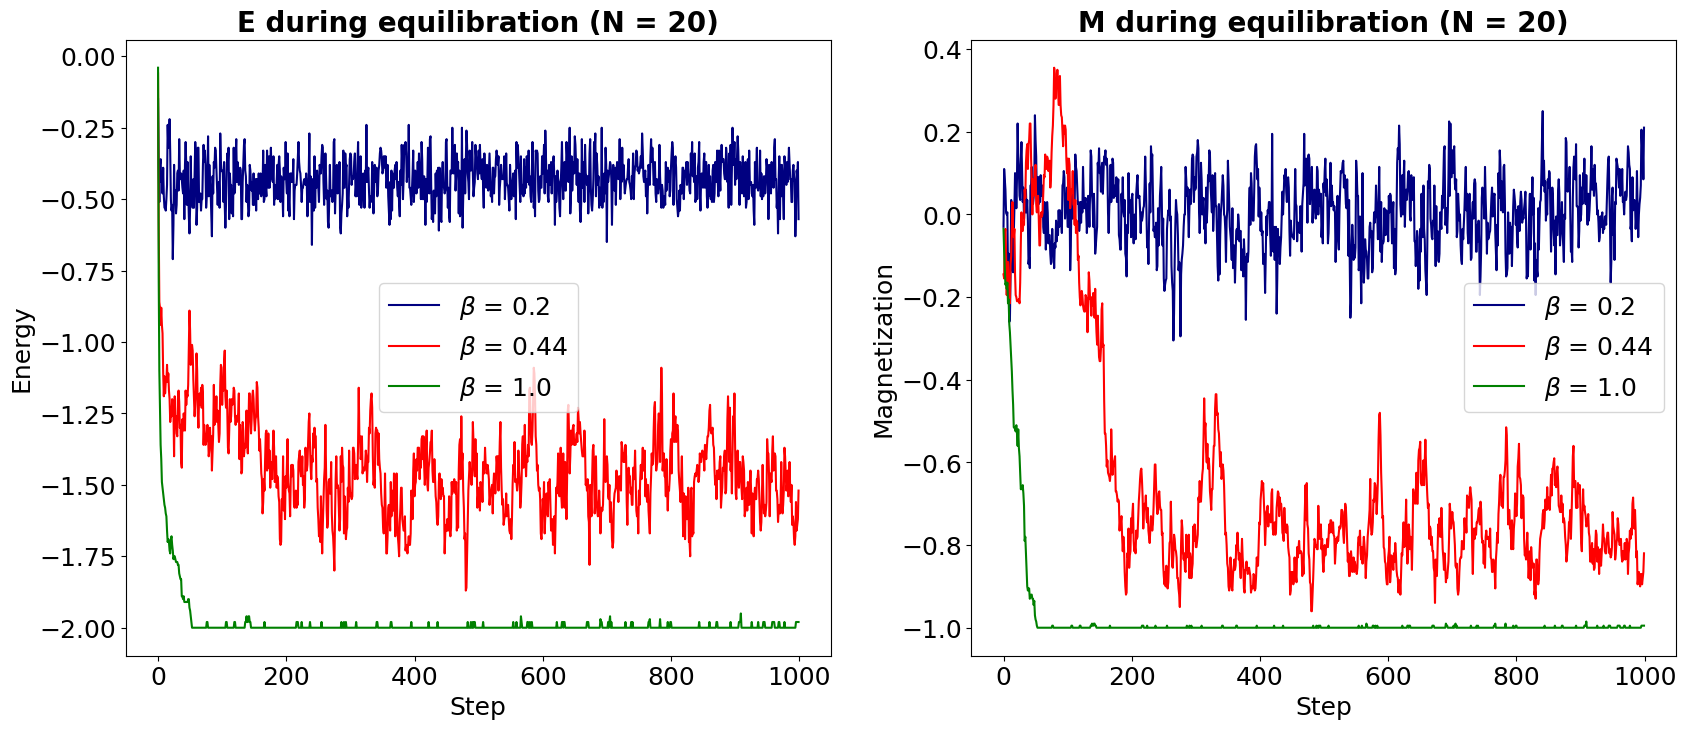

In [ ]:
N = 20 #size of lattice
eq_steps = 1000 #define number of equilibration steps
steps = 100 #define number of simulation steps
betas = np.array([0.2, 0.44, 1]) #values of beta to be used
col_map = np.array(["navy", "red", "green", "orange"])

#create plots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))
ax1.set_title(r"E during equilibration (N = {})".format(N), fontweight = "bold", fontsize = 20)
ax2.set_title(r"M during equilibration (N = {})".format(N), fontweight = "bold", fontsize = 20)
ax1.set_xlabel("Step", fontsize = 18)
ax2.set_xlabel("Step", fontsize = 18)
ax1.set_ylabel("Energy", fontsize = 18)
ax2.set_ylabel("Magnetization", fontsize = 18)
ax1.tick_params(axis="x",labelsize=18)
ax2.tick_params(axis="x",labelsize=18)
ax1.tick_params(axis="y",labelsize=18)
ax2.tick_params(axis="y",labelsize=18)

#loop over betas and compute values
for i in range(len(betas)):
    E_mean, M_mean, C, Chi, E_var, M_var, E_eq, M_eq, E, M = Ising(N, betas[i], eq_steps, steps)

    ax1.plot(E_eq/N**2, label = r"$\beta$ = {}".format(betas[i]), c = col_map[i])
    ax2.plot(M_eq/N**2, label = r"$\beta$ = {}".format(betas[i]), c = col_map[i])

ax1.legend(fontsize = 18)
ax2.legend(fontsize = 18)
plt.show()

We can also verify if the model behaves correctly by simulating a fully ordered state and observing if it reaches the same equilibrium state as a random initial state when the temperature is set.

---------- ISING MODEL ----------
N: 20 , beta: 0.3 , cluster: False , annealing: False 

Start equilibration...


  0%|          | 0/1000 [00:00<?, ?it/s]

End equilibration...

Start simulation...


  0%|          | 0/100 [00:00<?, ?it/s]

End simulation...
---------- ISING MODEL ----------
N: 20 , beta: 0.3 , cluster: False , annealing: False 

Start equilibration...


  0%|          | 0/1000 [00:00<?, ?it/s]

End equilibration...

Start simulation...


  0%|          | 0/100 [00:00<?, ?it/s]

End simulation...


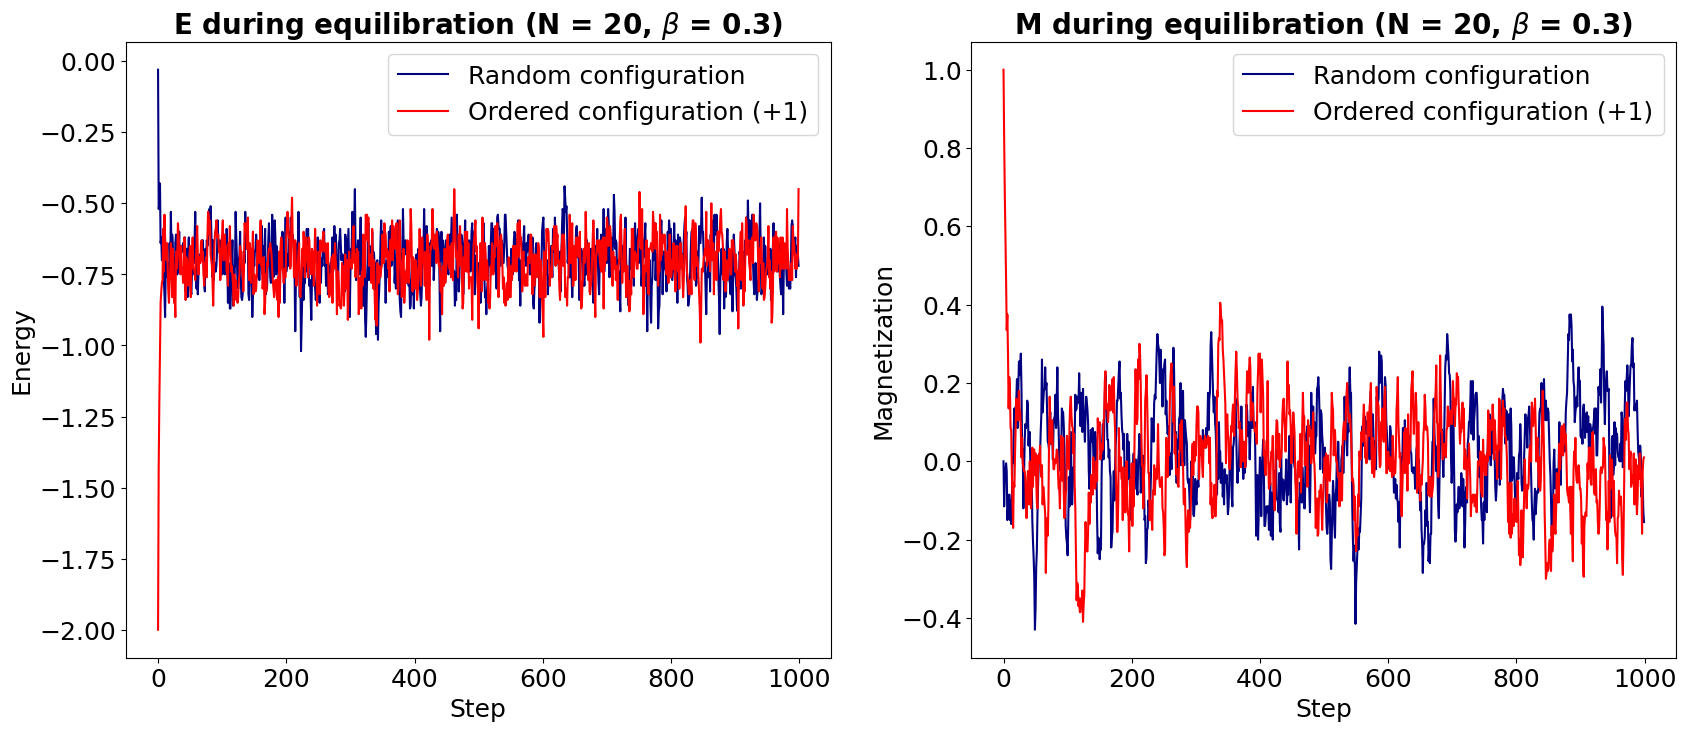

In [ ]:
N = 20 #size of the lattice
beta = 0.3 #beta to be used
eq_steps = 1000
steps=100

E_mean, M_mean, C, Chi, E_var, M_var, E_or, M_or, E, M = Ising(N, beta, eq_steps, steps, order=True)
E_mean, M_mean, C, Chi, E_var, M_var, E_ran, M_ran, E, M = Ising(N, beta, eq_steps, steps)

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax1.plot(E_ran/N**2, c = "navy", label = "Random configuration")
ax1.plot(E_or/N**2, c = "red", label = "Ordered configuration (+1)")
ax2.plot(M_ran/N**2, c = "navy", label = "Random configuration")
ax2.plot(M_or/N**2, c = "red", label = "Ordered configuration (+1)")
ax1.set_title(r"E during equilibration (N = {}, $\beta$ = {})".format(N, beta), fontweight = "bold", fontsize = 20)
ax2.set_title(r"M during equilibration (N = {}, $\beta$ = {})".format(N, beta), fontweight = "bold", fontsize = 20)
ax1.set_xlabel("Step", fontsize = 18)
ax2.set_xlabel("Step", fontsize = 18)
ax1.set_ylabel("Energy", fontsize = 18)
ax2.set_ylabel("Magnetization", fontsize = 18)
ax1.tick_params(axis="x",labelsize=18)
ax2.tick_params(axis="x",labelsize=18)
ax1.tick_params(axis="y",labelsize=18)
ax2.tick_params(axis="y",labelsize=18)
ax1.legend(fontsize = 18)
ax2.legend(fontsize = 18)
plt.show()


## **Phase transition**
**Brief Description of Phase Transition**

Phase transition refers to the transformation of a system from one phase to another. In the context of the 2D Ising model, it describes the transition between ordered and disordered magnetic states.

**Key Concepts:**

**Order Parameter**: The magnetization per spin,
𝑚
m, serves as the order parameter. It measures the degree of alignment of spins in the lattice.

**Critical Temperature (Tc):** The temperature at which the phase transition occurs. For the 2D Ising model with
𝐽
=
𝑘
𝐵
=
1
J=k
B
​
 =1, this is approximately
𝑇
𝑐
≈
2.269
T
c
​
 ≈2.269.
Below
𝑇
𝑐
T
c
​
 : The system is in an ordered state with non-zero magnetization, indicating a predominant alignment of spins.
Above
𝑇
𝑐
T
c
​
 : The system is in a disordered state with zero average magnetization, indicating random orientation of spins.
Spontaneous Magnetization: For temperatures below
𝑇
𝑐
T
c
​
 , the system exhibits spontaneous magnetization even in the absence of an external magnetic field.
Observables in Phase Transition:

Mean Magnetization<m>):Indicates the average magnetic moment per spin. It decreases as the temperature increases and drops to zero at
𝑇
𝑐
T
c
​
 .


**Mean Energy (<𝑒>**
<e>): Represents the average energy per spin. It typically shows a change in slope at
𝑇
𝑐
T
c
​
 .

**Susceptibility (𝜒χ):** Measures the response of the magnetization to changes in temperature. It peaks at
𝑇
𝑐
T
c
​
 .

**Specific Heat (𝑐c)**: Indicates the amount of heat required to change the temperature of the system. It also shows a peak at
𝑇
𝑐
T
c
​
 .


During a phase transition, the system undergoes significant changes in its physical properties, characterized by critical phenomena like diverging susceptibility and specific heat. This transition is driven by thermal fluctuations and interactions among spins in the lattice. Understanding phase transitions in the Ising model provides insights into critical behavior and collective phenomena in many physical systems.

In [ ]:
import numpy as np
from numba import jit, prange
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize state with a random configuration of spins
def init_state(N, order=False):
    if order:
        return np.ones((N, N))
    else:
        return np.random.choice([-1, 1], size=(N, N))

@jit(nopython=True, parallel=True)
def energy(state):
    N = state.shape[0]
    energy = 0
    for i in prange(N):
        for j in prange(N):
            nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N]
            energy -= state[i,j] * nn
    return energy / 2

@jit(nopython=True)
def update(state, beta):
    N = state.shape[0]
    for _ in range(N**2):
        i, j = np.random.randint(N), np.random.randint(N)
        dE = 2 * state[i, j] * (state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N])
        if dE < 0 or np.random.rand() < np.exp(-dE * beta):
            state[i, j] *= -1
    return state

def Ising(N, beta, eq_steps, steps, order=False):
    state = init_state(N, order)
    for _ in range(eq_steps):
        state = update(state, beta)
    E = np.zeros(steps)
    M = np.zeros(steps)
    for step in range(steps):
        state = update(state, beta)
        E[step] = energy(state)
        M[step] = np.sum(state)
    E_mean = np.mean(E)
    M_mean = np.mean(M)
    E_var = np.var(E)
    M_var = np.var(M)
    C = E_var / (N * N * beta**2)
    Chi = M_var / (N * N * beta)
    return E_mean, M_mean, C, Chi, E_var, M_var, E, M

# Parameters
N_T = 40
Ts = np.linspace(0.75, 3.75, endpoint=True, num=N_T)
betas = 1 / Ts

Ns = [10, 20, 30, 40, 50]
N_N = len(Ns)
eq_steps = int(1e4)
steps = int(1e4)

Es = np.zeros((N_N, N_T))
Ms = np.zeros((N_N, N_T))
Cs = np.zeros((N_N, N_T))
Chis = np.zeros((N_N, N_T))

for i, N in enumerate(Ns):
    print('Simulating N={}'.format(N))
    for j, beta in enumerate(tqdm(betas)):
        E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E, M = Ising(N, beta, eq_steps=eq_steps, steps=steps)
        Es[i, j] = E_mean
        Ms[i, j] = M_mean
        Cs[i, j] = C_mean
        Chis[i, j] = Chi_mean


Simulating N=10


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Simulating N=20


100%|██████████| 40/40 [01:03<00:00,  1.58s/it]


Simulating N=30


100%|██████████| 40/40 [01:41<00:00,  2.55s/it]


Simulating N=40


100%|██████████| 40/40 [03:23<00:00,  5.08s/it]


Simulating N=50


100%|██████████| 40/40 [04:34<00:00,  6.87s/it]


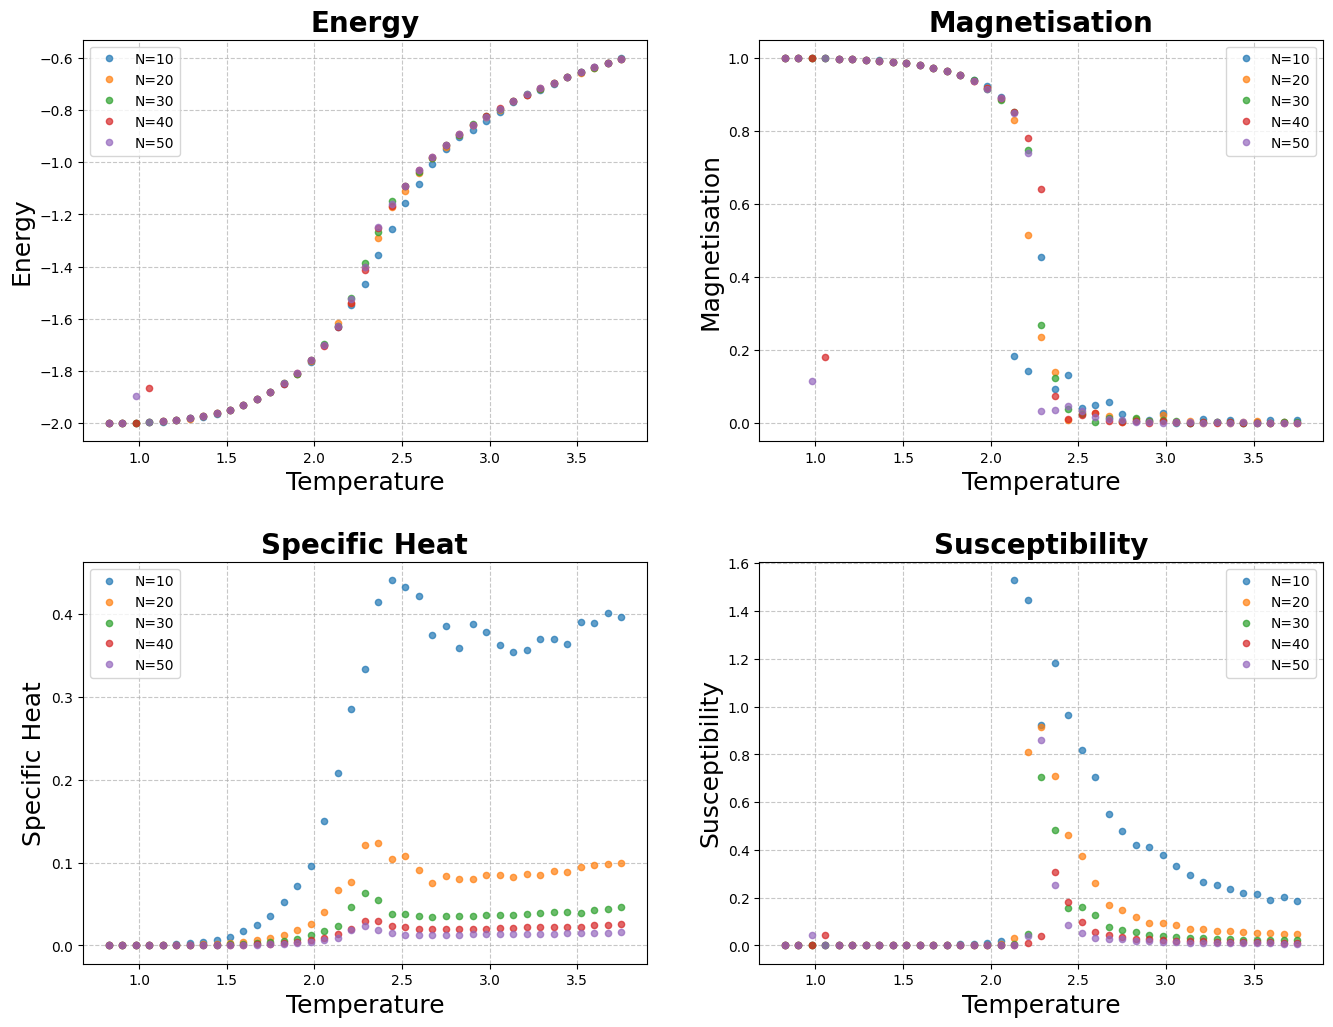

In [ ]:
def plot_values(Es, Ms, Cs, Chis, Ts, N, startN=0, endN=None):
    if endN is None:
        endN = Es.shape[0] - 1

    titles = ['Energy', 'Magnetisation', 'Specific Heat', 'Susceptibility']
    physical_quantities = [Es, np.abs(Ms), Cs, Chis]
    plt.figure(figsize=(16, 12))

    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.set_title(titles[i], fontsize=20, fontweight="bold")
        ax.grid(True, linestyle='--', alpha=0.7)

        for j in range(startN, endN + 1):
            ax.plot(Ts[1:], physical_quantities[i][j][1:] / N[j]**2, '.', markersize=9, label='N=' + str(N[j]), alpha=0.7)
            ax.legend()

    plt.subplots_adjust(hspace=0.3)
    plt.show()

# Example usage:
# Assuming Es, Ms, Cs, Chis, Ns, and Ts are already defined as in the previous code

# Plot Energy, Magnetization, Specific Heat Capacity, and Susceptibility vs Temperature
plot_values(Es, Ms, Cs, Chis, Ts, Ns)


In [ ]:
plot_values(Es, Ms, Cs, Chis, Ts, Ns, startN=0)

## **Microscopic configurations**
Microscopic configurations refer to the specific arrangements of microscopic elements within a system, typically in the context of statistical mechanics and computational physics. In the case of the Ising model and similar lattice-based models, microscopic configurations specifically describe how individual lattice sites are occupied or oriented.

For the 2D Ising model, which consists of a square lattice where each lattice site can have a spin value of +1 or -1, a microscopic configuration would be a complete specification of all spin values across the lattice. This configuration can vary over time as the system evolves according to its dynamics, such as through the Metropolis Monte Carlo algorithm in the case of the Ising model.

Microscopic configurations are fundamental to understanding and simulating the behavior of physical systems at the atomic or molecular level. They encode the detailed state of the system's constituents, which collectively determine macroscopic properties such as magnetization, energy, and susceptibility.

In simulation studies, microscopic configurations are often sampled at different times to analyze how the system's properties evolve over time or in response to changes in external conditions like temperature or magnetic field. These configurations are essential for calculating observables and statistical quantities that characterize the system's thermodynamic behavior.

In this project, we will consider the dynamics of the 2D Ising model starting from a fully disordered initial configuration.

In [ ]:
class Ising():
    '''
    Simulating Microscopic configuration for the Ising model
    '''

    def mcmove(self, config, N, beta):
        '''
        Monte Carlo moves using the Metropolis algorithm
        '''
        for i in range(N):
            for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s = config[a, b]
                nb = config[(a + 1) % N, b] + config[a, (b + 1) % N] + config[(a - 1) % N, b] + config[a, (b - 1) % N]
                cost = 2 * s * nb
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost * beta):
                    s *= -1
                config[a, b] = s
        return config

    def simulate(self, t):
        ''' Simulate the Ising model '''
        # Initialize the lattice
        N, temp = 100, t
        config = 2 * np.random.randint(2, size=(N, N)) - 1
        f = plt.figure(figsize=(15, 15), dpi=80)
        self.configPlot(f, config, 0, N, 1)

        msrmnt = 4001
        plot_indices = [100, 200, 400, 800, 1600, 2400, 3000, 4000]
        plot_counter = 2
        for i in range(msrmnt):
            self.mcmove(config, N, 1.0 / temp)
            if i in plot_indices:
                self.configPlot(f, config, i, N, plot_counter)
                plot_counter += 1

        plt.show()

    def configPlot(self, f, config, i, N, n_):
        ''' Plot the configuration '''
        X, Y = np.meshgrid(range(N), range(N))
        sp = f.add_subplot(3, 3, n_)
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)
        plt.pcolormesh(X, Y, config, cmap=plt.cm.plasma)
        plt.axis('tight')



**Microscopic configurations with T = 2.5** ($\beta$ < $\beta_{c}$)

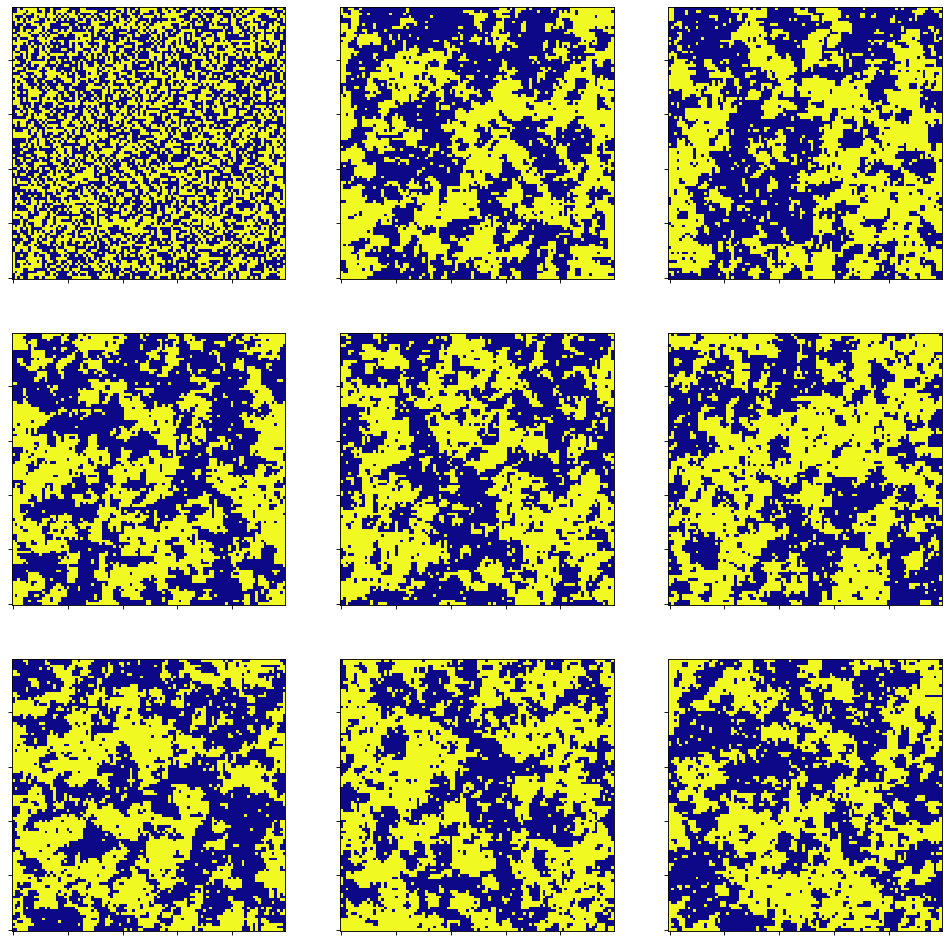

In [ ]:
rm = Ising()
rm.simulate(2.5)

**Microscopic configurations with T = 2** ($\beta$ < $\beta_{c}$)

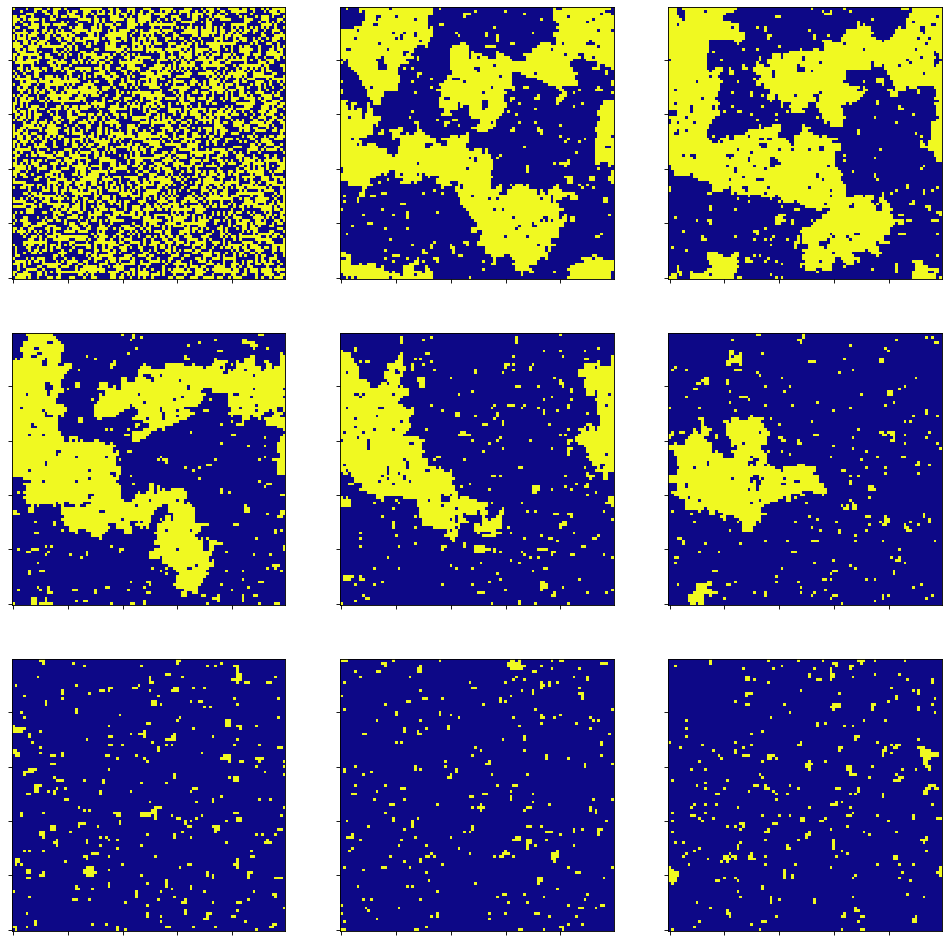

In [ ]:
rm.simulate(2)

# **Interperation of Numerical Results**
**Thermalization Time**

In the numerical simulations, a square lattice with
𝐿
=
100
L=100 was used, interaction energy
𝐽
=
1
J=1, and the Boltzmann constant
𝑘
𝐵
=
1
k
B
​
 =1. Time is measured in units of
𝑁
sw
=
𝐿
2
N
sw
​
 =L
2
 , where
𝑁
sw
N
sw
​
  denotes the number of sweeps.


**Magnetization vs Time (Left Panel for 𝛽=0.4 β=0.4)**
The left plot shows the magnetization per site as a function of time for
𝛽
=
0.4
β=0.4.
The curves for different initial data (red, black, and blue) indicate that magnetization fluctuates around zero and does not exhibit a clear ordering.
This suggests that at
𝛽
=
0.4
β=0.4 (which corresponds to a higher temperature since
𝛽
=
1
/
𝑇
β=1/T), the system remains disordered with no significant magnetization.

**Magnetization vs Time (Right Panel for β=0.5):**The right plot shows the magnetization per site as a function of time for
𝛽
=
0.5
β=0.5.
The curves for different initial data (red, black, and blue) show distinct behaviors, with some initial conditions leading to positive magnetization and others to negative magnetization.
This indicates that at
𝛽
=
0.5
β=0.5 (which corresponds to a lower temperature), the system shows signs of ordering, where magnetization converges to non-zero values, reflecting a phase transition to an ordered state.


**Energy vs Time (Left Panel for β=0.4):**
The left plot shows the energy per site as a function of time for
𝛽
=
0.4
β=0.4.
The energy curves for different initial conditions (red, black, and blue) remain relatively constant over time, indicating the system is in a disordered phase with high thermal energy.

**Energy vs Time (Right Panel for β=0.5):**
The right plot shows the energy per site as a function of time for
𝛽
=
0.5
β=0.5.
The energy decreases initially and stabilizes at lower values compared to
𝛽
=
0.4
β=0.4.
This suggests that as the system cools down (
𝛽
=
0.5
β=0.5), it loses energy and moves towards a more ordered state, consistent with the observed magnetization behavior.

**Summary**

The magnetization plots indicate that at lower temperatures (
𝛽
=
0.5
β=0.5), the system exhibits spontaneous magnetization, signaling a phase transition to an ordered state. At higher temperatures (
𝛽
=
0.4
β=0.4), the system remains disordered with magnetization fluctuating around zero.
The energy plots show that at
𝛽
=
0.5
β=0.5, the system reaches a lower energy state compared to
𝛽
=
0.4
β=0.4, reinforcing the observation of the phase transition.
These results align with theoretical expectations of the 2D Ising model, where a phase transition occurs at a critical temperature, leading to spontaneous magnetization and lower energy states in the ordered phase.

**Microscopic Configuration**
We investigated the dynamics of a 2D Ising model starting from a fully disordered initial configuration. We explore two scenarios: one where β = 0.4 < βc and another where β = 0.5 > βc. In our visualization, spins with a value of +1 are represented in yellow, while spins with a value of -1 are shown in black.


# **Conclusion**
In conclusion, our Monte Carlo simulation of the 2D Ising model has provided valuable insights into the behavior of magnetic systems at different temperatures. By analyzing the evolution of magnetization, energy, and spatial configurations over time, we observed distinct phase transitions and critical phenomena. For β values below the critical point (βc), the system exhibited a disordered phase with fluctuating magnetization and energy. Conversely, above βc, clear signs of ordering emerged, characterized by significant changes in magnetization profiles and the formation of magnetic domains. These findings align well with theoretical predictions and experimental observations, validating the effectiveness of Monte Carlo methods in studying complex magnetic system such as the  Square Lattice 2D-Ising Model.